## Pneumonia Detection - Deep Learning model (using VGG16 as base)



In [1]:
# Import all required libraries 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

import tensorflow as tf
from skimage import io
import sklearn
from random import sample 
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten, Conv2D, MaxPooling2D
from keras.models import Sequential, Model
from keras.applications.vgg16 import VGG16
from keras.applications.resnet import ResNet50 
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

from sklearn.preprocessing import binarize
import seaborn as sns

from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, plot_precision_recall_curve, f1_score, confusion_matrix

# Import any other stats/DL/ML packages you may need here. E.g. Keras, scikit-learn, etc.

Using TensorFlow backend.


## Do some early processing of your metadata for easier model training:

In [2]:
## Below is some helper code to read all of your full image filepaths into a dataframe for easier manipulation
## Load the NIH data to all_xray_df
all_xray_df = pd.read_csv('/data/Data_Entry_2017.csv')
all_image_paths = {os.path.basename(x): x for x in 
                   glob(os.path.join('/data','images*', '*', '*.png'))}
print('Scans found:', len(all_image_paths), ', Total Headers', all_xray_df.shape[0])
all_xray_df['path'] = all_xray_df['Image Index'].map(all_image_paths.get)
all_xray_df.sample(3)

Scans found: 112120 , Total Headers 112120


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11,path
84448,00020773_000.png,No Finding,0,20773,20,M,AP,2500,2048,0.168,0.168,NaN,/data/images_009/images/00020773_000.png
13064,00003400_000.png,Infiltration|Mass,0,3400,25,F,PA,2500,2048,0.171,0.171,NaN,/data/images_002/images/00003400_000.png
66413,00016420_002.png,Atelectasis|Consolidation,2,16420,38,F,PA,2900,2936,0.143,0.143,NaN,/data/images_008/images/00016420_002.png


In [3]:
## Here you may want to create some extra columns in your table with binary indicators of certain diseases 
## rather than working directly with the 'Finding Labels' column

# Create Pneumonia binary column

In [4]:
df1 = all_xray_df['Finding Labels'].str.get_dummies(sep='|')

In [5]:
df2 = pd.concat((all_xray_df,df1),axis=1)


In [6]:
# Add new column for Pneumonia class
df2['Pneumonia_Class'] = df2['Pneumonia']

In [7]:
# Populate Pneumonia class value
df2.loc[df2['Pneumonia'] ==1,'Pneumonia_Class']= 'Pneumonia'

In [8]:
# Populate Non-Pneumonia class value
df2.loc[df2['Pneumonia'] !=1,'Pneumonia_Class']= 'Non Pneumonia'

In [9]:
df2['Pneumonia_Class'].value_counts()

Non Pneumonia    110689
Pneumonia          1431
Name: Pneumonia_Class, dtype: int64

In [10]:
df2.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,...,Fibrosis,Hernia,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,Pneumonia_Class
0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,0.143,...,0,0,0,0,0,0,0,0,0,Non Pneumonia
1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,0.143,...,0,0,0,0,0,0,0,0,0,Non Pneumonia
2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,0.168,...,0,0,0,0,0,0,0,0,0,Non Pneumonia
3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,0.171,...,0,0,0,0,1,0,0,0,0,Non Pneumonia
4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,0.143,...,0,1,0,0,0,0,0,0,0,Non Pneumonia


## Create your training and testing data:

In [12]:
from sklearn.model_selection import train_test_split

In [13]:
train_df2,valid_df2 = train_test_split(df2,test_size=0.2,stratify=df2['Pneumonia'])

In [14]:
#Refine Train dataset to have 50:50 split for Pneumonia

pindex = train_df2[train_df2['Pneumonia']==1].index.tolist()
npindex = train_df2[train_df2['Pneumonia']!=1].index.tolist()
np_sample = sample(npindex,len(pindex))

#Create train dataset ( 50:50 split for Pneumonia)
train_df2 = train_df2.loc[pindex + np_sample]

In [15]:
# Refine validation set to have a 20-80% proportion (20% positive and 80% negative) for pneumonia to reflect the imbalance
# Create sample index for validation dataset ( 20 % Pneumonia and 80% non-Pneuomonia cases)

val_pindex = valid_df2[valid_df2['Pneumonia']==1].index.tolist()
val_npindex = valid_df2[valid_df2['Pneumonia']!=1].index.tolist()
val_np_sample = sample(val_npindex,4*len(val_pindex))

#Create train dataset ( 50:50 split for Pneumonia)
valid_df2 = valid_df2.loc[val_pindex + val_np_sample]

In [16]:
train_Pneumonia_count= len(train_df2[train_df2['Pneumonia']==1])
valid_Pneumonia_count= len(valid_df2[valid_df2['Pneumonia']==1])

In [17]:
#Print all Training and Test dataset record counts

print(f'Total number of records in this dataset is : {len(df2)}')
print(f'                ')
print(f'###Training Dataset Information### :')
print(f'Total number of records in the training dataet is : {len(train_df2)}')
print(f'Total number of Pneumonia records in the training dataet is: {train_Pneumonia_count}')
print(f'Total number of Non-Pneumonia records in the training dataet is: {len(train_df2) - train_Pneumonia_count}')
print(f'% of Pneumonia cases in the training dataset is: {train_Pneumonia_count*100 /len(train_df2)}')
print(f'% of Non-Pneumonia cases in the training dataset is: {(len(train_df2) - train_Pneumonia_count)*100 /len(train_df2)}')

print(f'                ')
print(f'### Validation Dataset Information### :')
print(f'Total number of records in the validation dataet is : {len(valid_df2)}')
print(f'Total number of Pneumonia records in the validation dataet is: {valid_Pneumonia_count}')
print(f'Total number of Non-Pneumonia records in the validation dataet is: {len(valid_df2) - valid_Pneumonia_count}')
print(f'% of Pneumonia cases in the validation dataset is: {valid_Pneumonia_count*100 /len(valid_df2)}')
print(f'% of Non-Pneumonia cases in the validation dataset is: {(len(valid_df2) - valid_Pneumonia_count)*100 /len(valid_df2)}')



Total number of records in this dataset is : 112120
                
###Training Dataset Information### :
Total number of records in the training dataet is : 2290
Total number of Pneumonia records in the training dataet is: 1145
Total number of Non-Pneumonia records in the training dataet is: 1145
% of Pneumonia cases in the training dataset is: 50.0
% of Non-Pneumonia cases in the training dataset is: 50.0
                
### Validation Dataset Information### :
Total number of records in the validation dataet is : 1430
Total number of Pneumonia records in the validation dataet is: 286
Total number of Non-Pneumonia records in the validation dataet is: 1144
% of Pneumonia cases in the validation dataset is: 20.0
% of Non-Pneumonia cases in the validation dataset is: 80.0


# Now we can begin our model-building & training

In [ ]:
# Perform Image augementation for model training 

In [19]:
IMG_SIZE =(224,224)

In [20]:
idg = ImageDataGenerator(rescale=1. / 255.0,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.1, 
                              rotation_range=20, 
                              shear_range = 0.1,
                              zoom_range=0.1)

train_gen = idg.flow_from_dataframe(dataframe=train_df2, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_Class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 128
                                         )

Found 2290 validated image filenames belonging to 2 classes.


In [21]:
idg = ImageDataGenerator(rescale=1. / 255.0)

val_gen = idg.flow_from_dataframe(dataframe=valid_df2, 
                                         directory=None, 
                                         x_col = 'path',
                                         y_col = 'Pneumonia_Class',
                                         class_mode = 'binary',
                                         target_size = IMG_SIZE, 
                                         batch_size = 64
                                         )

Found 1430 validated image filenames belonging to 2 classes.


In [22]:
## May want to pull a single large batch of random validation data for testing after each epoch:
valX, valY = val_gen.next()

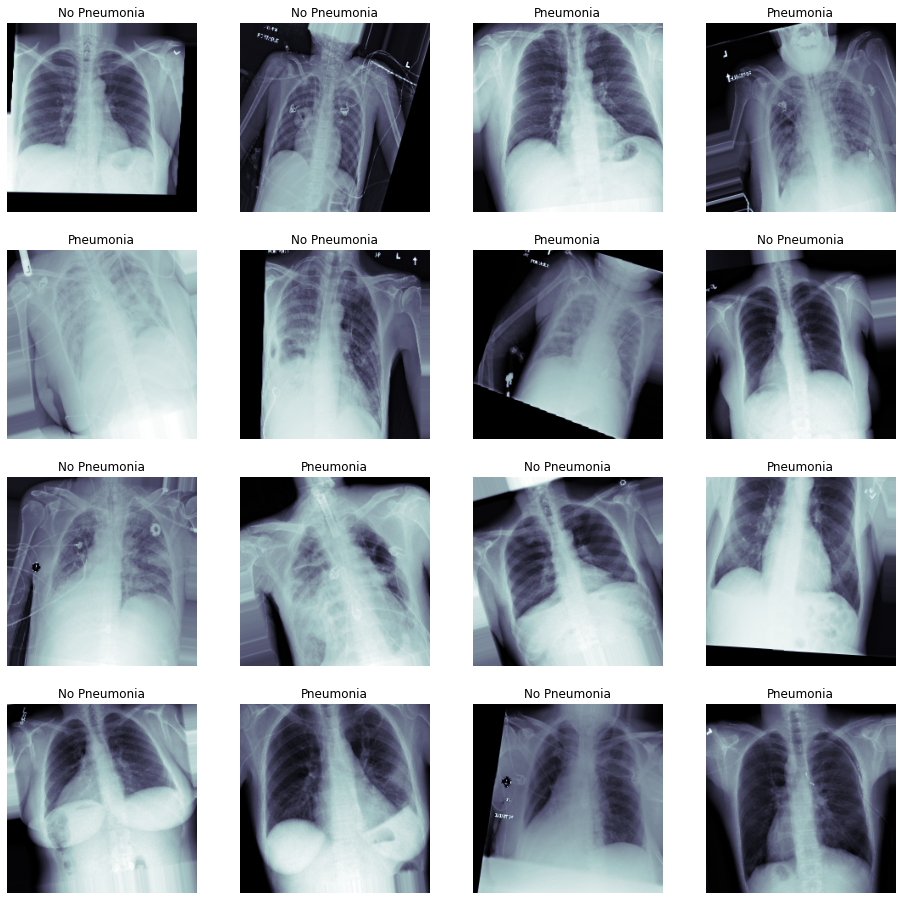

In [23]:
## May want to look at some examples of our augmented training data. 
## This is helpful for understanding the extent to which data is being manipulated prior to training, 
## and can be compared with how the raw data look prior to augmentation

t_x, t_y = next(train_gen)
fig, m_axs = plt.subplots(4, 4, figsize = (16, 16))
for (c_x, c_y, c_ax) in zip(t_x, t_y, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        c_ax.set_title('Pneumonia')
    else:
        c_ax.set_title('No Pneumonia')
    c_ax.axis('off')

## Build your model: 

Use pre-trained VGG16 network downloaded from Keras for fine-tuning

In [24]:
model = VGG16(include_top=True, weights='imagenet')
model.summary()

553467904/553467096 [==============================] - 6s 0us/step
Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
____________________________________________________________

In [25]:
transfer_layer = model.get_layer('block5_pool')
vgg_model = Model(inputs=model.input,
                   outputs=transfer_layer.output)

In [26]:
## Now, choose which layers of VGG16 we actually want to fine-tune (if any)
## Here, we'll freeze all but the last convolutional layer
for layer in vgg_model.layers[0:17]:
    layer.trainable = False

In [27]:
for layer in vgg_model.layers:
    print(layer.name, layer.trainable)

input_1 False
block1_conv1 False
block1_conv2 False
block1_pool False
block2_conv1 False
block2_conv2 False
block2_pool False
block3_conv1 False
block3_conv2 False
block3_conv3 False
block3_pool False
block4_conv1 False
block4_conv2 False
block4_conv3 False
block4_pool False
block5_conv1 False
block5_conv2 False
block5_conv3 True
block5_pool True


In [28]:
# Build Pneumonia Detection CNN model using VGG16 as base model

# Initialize CNN model
Pneumonia_Classifier = Sequential()
Pneumonia_Classifier.add(vgg_model)

#Flatten CNN model
Pneumonia_Classifier.add(Flatten())

# Add drop-outs to avoid overfitting
Pneumonia_Classifier.add(Dropout(0.5))

# Add fully connected Dense layer ( hidden layer with 1024 neurons)
Pneumonia_Classifier.add(Dense(units=1024,activation='relu'))

Pneumonia_Classifier.add(Dropout(0.5))

# Add fully connected Dense layer ( hidden layer with 512 neurons)
Pneumonia_Classifier.add(Dense(units=512,activation='relu'))

# Add fully connected Dense layer ( hidden layer with 256 neurons)
Pneumonia_Classifier.add(Dropout(0.5))
Pneumonia_Classifier.add(Dense(units=256,activation='relu'))

# Add fully connected Dense layer ( hidden layer with 64 neurons)
Pneumonia_Classifier.add(Dropout(0.5))
Pneumonia_Classifier.add(Dense(units=64,activation='relu'))

#Final output layer ( Number of neurons as 1 since its binary classification : Pneumonia or No Pneumonia)
Pneumonia_Classifier.add(Dense(units=1,activation='sigmoid'))

In [29]:
## Set our optimizer, loss function, and learning rate
optimizer = Adam(lr=1e-4)
loss = 'binary_crossentropy'
metrics = ['binary_accuracy']

In [30]:
# Compile Pneumonia Classifier
Pneumonia_Classifier.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [31]:
Pneumonia_Classifier.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model_1 (Model)              (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1024)              25691136  
_________________________________________________________________
dropout_2 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_3 (Dropout)          (None, 512)              

In [33]:
#Add checkpoints to your model

weight_path="{}_new_model.best.hdf5".format('xray_class')

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1,save_best_only=True, mode='min', save_weights_only = True)
early = EarlyStopping(monitor="val_loss", mode="min", patience=10)
callbacks_list = [checkpoint, early]

### Start training! 

In [34]:
#Train model 
history = Pneumonia_Classifier.fit_generator(train_gen, 
                           validation_data = (valX, valY), 
                           epochs = 30, 
                           callbacks = callbacks_list)

Epoch 1/30
18/18 [==============================] - 79s 4s/step - loss: 1.0040 - binary_accuracy: 0.4913 - val_loss: 0.6996 - val_binary_accuracy: 0.4844

Epoch 00001: val_loss improved from inf to 0.69957, saving model to xray_class_new_model.best.hdf5
Epoch 2/30
18/18 [==============================] - 79s 4s/step - loss: 0.7677 - binary_accuracy: 0.5140 - val_loss: 0.7878 - val_binary_accuracy: 0.1875

Epoch 00002: val_loss did not improve from 0.69957
Epoch 3/30
18/18 [==============================] - 66s 4s/step - loss: 0.7345 - binary_accuracy: 0.5131 - val_loss: 0.7481 - val_binary_accuracy: 0.1875

Epoch 00003: val_loss did not improve from 0.69957
Epoch 4/30
18/18 [==============================] - 60s 3s/step - loss: 0.7180 - binary_accuracy: 0.5114 - val_loss: 0.7147 - val_binary_accuracy: 0.3594

Epoch 00004: val_loss did not improve from 0.69957
Epoch 5/30
18/18 [==============================] - 61s 3s/step - loss: 0.7270 - binary_accuracy: 0.5004 - val_loss: 0.7139 - va

In [48]:
# Make some predictions

Pneumonia_Classifier.load_weights(weight_path)

pred_Y = Pneumonia_Classifier.predict(valX, batch_size = 64, verbose = True)

64/64 [==============================] - 1s 10ms/step


In [36]:
def plot_roc_curve(ground_truth, probability):
    ## YOUR CODE HERE
    fpr, tpr, _ = roc_curve(ground_truth, probability)
    plt.figure(figsize = (12, 8))
    plt.style.use("ggplot")
    plt.plot(fpr, tpr, label = f"Pneumonia AUC Score: {auc(fpr, tpr)}")
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC-Curve')
    plt.legend()

## what other performance statistics do you want to include here besides AUC? 

def plot_precision_recall_curve(gt, prob):
    
    precision, recall, threshold = precision_recall_curve(gt, prob)
    
    plt.figure(figsize = (12, 8))
    plt.style.use("ggplot")
    plt.plot(recall, precision, label =  f"Pneumonia AP Score: {average_precision_score(gt, prob)}")
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('PR-Curve')
    plt.legend()
    
def f1_score(p, r):
    if(p == 0 or r == 0):
        return 0
    return 2 * p * r / (p + r)

#Also consider plotting the history of your model training:

def plot_history(history):
    
    fig, axs = plt.subplots(1, 2, figsize = (12, 5))
    axs = axs.flatten()
    plt.style.use("ggplot")
    N = len(history.history["loss"])
    
    axs[0].plot(np.arange(N), history.history["loss"], label = 'train_loss')
    axs[0].plot(np.arange(N), history.history["val_loss"], label = 'val_loss')
    axs[0].set_xlabel('# epochs')
    axs[0].set_ylabel('loss')
    axs[0].set_title('Loss curve')
    axs[0].legend()
    
    axs[1].plot(np.arange(N), history.history["binary_accuracy"], label = 'train_binary_accuracy')
    axs[1].plot(np.arange(N), history.history["val_binary_accuracy"], label = 'val_binary_accuracy')
    axs[1].set_xlabel('# epochs')
    axs[1].set_ylabel('accuracy')
    axs[1].set_title('Accuracy curve')
    axs[1].legend()
    
    return

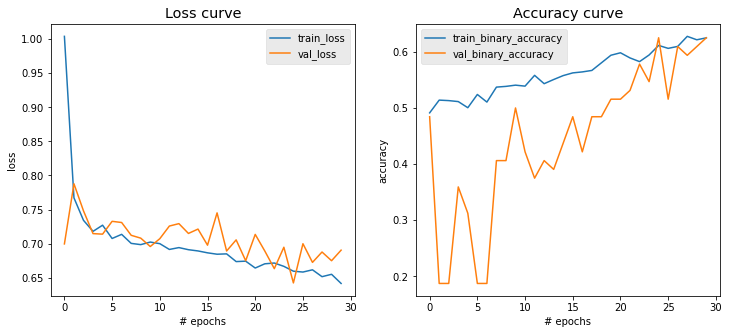

In [37]:
## plot figures
plot_history(history)

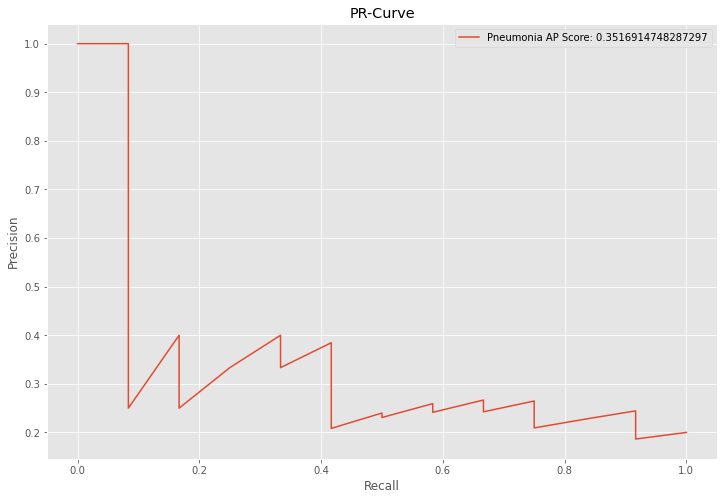

In [38]:
plot_precision_recall_curve(valY, pred_Y)

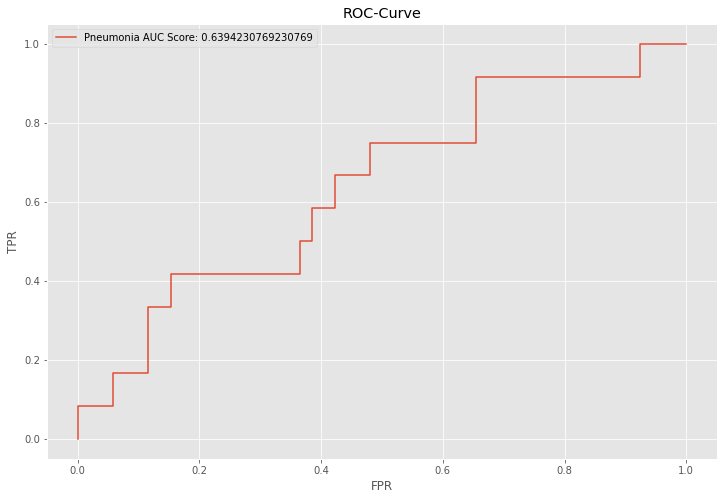

In [39]:
plot_roc_curve(valY, pred_Y)

In [40]:
## Find the threshold that optimize your model's performance,
## and use that threshold to make binary classification. Make sure you take all your metrics into consideration.

# Todo
precision, recall, threshold = precision_recall_curve(valY, pred_Y.ravel())
f1_scores = [f1_score(precision[i], recall[i]) for i in range(len(threshold))]

Text(0.5, 1.0, 'F1-score on different thresholds')

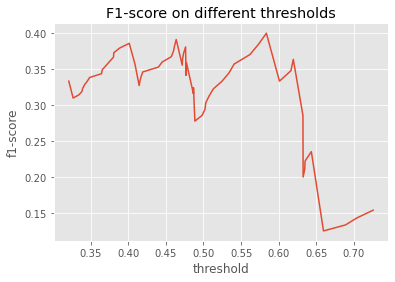

In [41]:
plt.figure()
plt.style.use("ggplot")
plt.plot(threshold, f1_scores)
plt.xlabel('threshold')
plt.ylabel('f1-score')
plt.title('F1-score on different thresholds')

In [42]:
thresh_idx = np.argmax(f1_scores)
thresh = threshold[thresh_idx]
print(f"Precision at {thresh} threshold is {precision[thresh_idx]}.")
print(f"Recall at {thresh} threshold is {recall[thresh_idx]}.")
print(f"F1 score at {thresh} threshold is {f1_scores[thresh_idx]}.")

Precision at 0.5836243033409119 threshold is 0.38461538461538464.
Recall at 0.5836243033409119 threshold is 0.4166666666666667.
F1 score at 0.5836243033409119 threshold is 0.4.


In [ ]:
# Overall,  we are able to achieve F1 Score 0.4 at Threshold value 0.5836243033409119.  
# This is better than Radiologist average F1 score , which is at 0.387 as per CheXNet paper (https://arxiv.org/pdf/1711.05225.pdf)

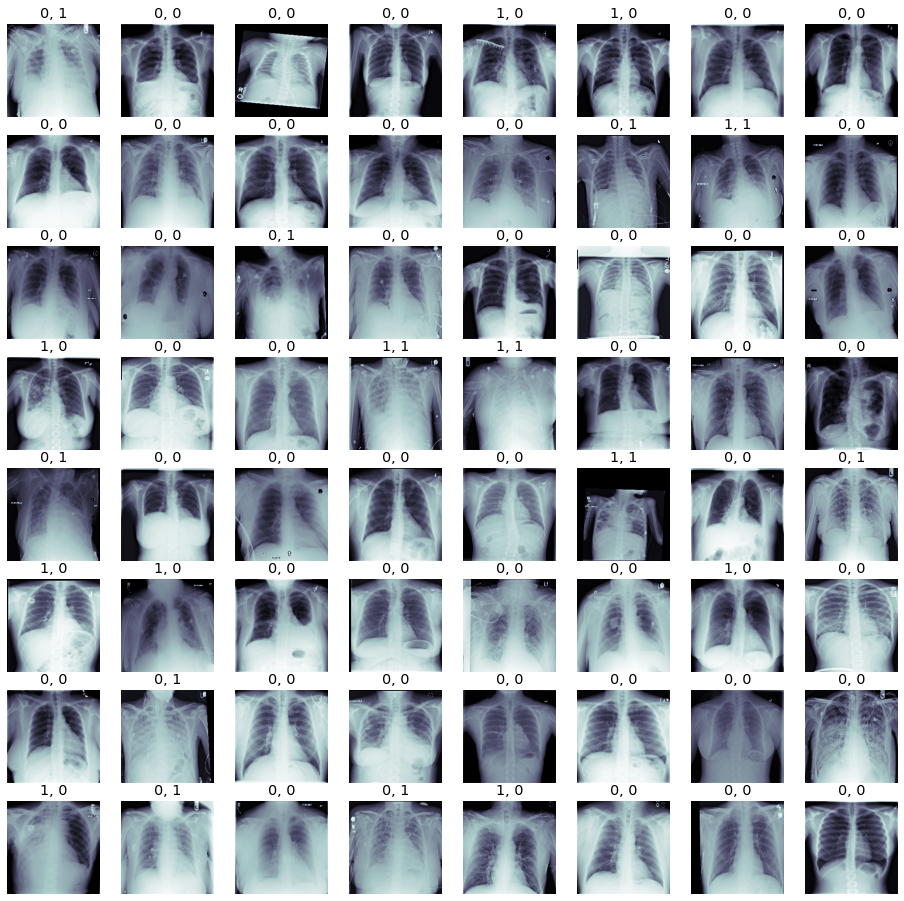

In [43]:
## Review True vs. predicted value for our model 

fig, m_axs = plt.subplots(8, 8, figsize = (16, 16))
i = 0
for (c_x, c_y, c_ax) in zip(valX, valY, m_axs.flatten()):
    c_ax.imshow(c_x[:,:,0], cmap = 'bone')
    if c_y == 1: 
        if pred_Y[i] > thresh:
            c_ax.set_title('1, 1')
        else:
            c_ax.set_title('1, 0')
    else:
        if pred_Y[i] > thresh: 
            c_ax.set_title('0, 1')
        else:
            c_ax.set_title('0, 0')
    c_ax.axis('off')
    i=i+1

In [45]:
## Just save model architecture to a .json:

Pneumonia_Classifier_json = Pneumonia_Classifier.to_json()
with open("Pneumonia_Classifier.json", "w") as json_file:
    json_file.write(Pneumonia_Classifier_json)